In [56]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os
import re
import numpy as np
import torch
from torch.multiprocessing import Process, set_start_method
from functools import partial
from utils import record_stats, display_stats, distribute
from pathlib import Path 

    
n_cpu = 16
n_instance = -1
nodesels =  ['expert_dummy', 'gnn_dummy_nprimal=2', 'ranknet_dummy_nprimal=2', 'svm_dummy_nprimal=2', 'estimate_dummy']
nodesels =  ['expert_dummy', 'estimate_dummy']
problem = 'WPMS'
data_partition = 'transfer'

normalize = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
verbose = True
on_log = False
default = True

instances =  list(Path(os.path.join(os.path.abspath(''), 
                           f"./problem_generation/data/{problem}/{data_partition}")).glob("*.lp"))

print(len(instances))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
75


In [57]:

processes = [  Process(name=f"worker {p}", 
               target=partial(record_stats,
                              nodesels=nodesels,
                              instances=instances[p1:p2], 
                              problem=problem,
                              device=torch.device(device),
                              normalize=normalize,
                              verbose=verbose,
                              default=default))
        for p,(p1,p2) in enumerate(distribute(n_instance, n_cpu)) ]  


try:
    set_start_method('spawn')
except RuntimeError:
    ''

a = list(map(lambda p: p.start(), processes)) #run processes
b = list(map(lambda p: p.join(), processes)) #join processes

In [59]:



problems = [  'WPMS'  ]

nodesels = [ 'expert_dummy', 'gnn_dummy_nprimal=2', 'ranknet_dummy_nprimal=2', 'svm_dummy_nprimal=2', 'estimate_dummy']
nodesels =  ['expert_dummy', 'estimate_dummy']
for d in ['transfer']:
    for p in problems:

        instances =  list(Path(os.path.join(os.path.abspath(''), 
                                   f"./problem_generation/data/{p}/{d}")).glob("*.lp"))
        print(f"BENCHMARK {p} {d}")
        nnode_means = display_stats(p, nodesels, instances, 0, 0, default=True)
        
    

BENCHMARK WPMS transfer
Statistics on WPMS for problem size in [0, 0]
  default 
      Mean over n=75 instances : 
        |- B&B Tree Size   :  357  ± 2
        |- Solving Time    :  25.3  ± 1.7
-------------------------------------------------
  expert_dummy 
      Mean over n=75 instances : 
        |- B&B Tree Size   :  670  ± 3
        |- Solving Time    :  23.8  ± 2.1
        |- nodecomp calls  :  9122
           |---   inference nodecomp calls:      29
        |- nodesel calls   :  998
-------------------------------------------------
  estimate_dummy 
      Mean over n=75 instances : 
        |- B&B Tree Size   :  436  ± 2
        |- Solving Time    :  29.0  ± 1.9
        |- nodecomp calls  :  10483
        |- nodesel calls   :  1000
-------------------------------------------------


19

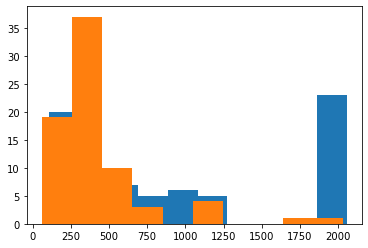

In [60]:
from matplotlib.pyplot import hist
hist(nnode_means['expert_dummy'].values())
hist(nnode_means['default'].values())

ins_to_delete = []
for ins in instances:
    instance = str(ins)
    try:
        if nnode_means['estimate_dummy'][instance] < 250:
            ins_to_delete.append(instance)
    except:
        ''

len(ins_to_delete)

In [50]:
for i in ins_to_delete:
    os.remove(i)
    os.remove(str(i).replace('.lp', '.sol'))